In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import plots
import functions
import glob
import os
import pandas as pd
from scipy.interpolate import griddata
from shapely.geometry import LineString, Point, Polygon
import geopandas as gpd    
from pyproj import Geod
from scipy.interpolate import RegularGridInterpolator

## Loading data

In [3]:
SwotData = "/Users/dihyachaal/Desktop/Data/PassGroups/"
pass_dirs = sorted([d for d in glob.glob(os.path.join(SwotData, "*")) if os.path.isdir(d)])
bathy = xr.open_dataset('GEBCO_14_May_2025_b03991ce039e/gebco_2024_n75.0_s42.0_w-80.0_e-40.0.nc') 

In [4]:
DataGrid = xr.open_dataset('GriddedData/gridded_swot_timeseries.nc')
monthly_idx = DataGrid.groupby('time.month').groups
jan_idx = monthly_idx[1]
ds_jan = DataGrid.isel(time=jan_idx)

feb_idx = monthly_idx[2]
ds_feb = DataGrid.isel(time=feb_idx)

march_idx = monthly_idx[3]
march_jan = DataGrid.isel(time=march_idx)

apr_idx = monthly_idx[4]
apr_jan = DataGrid.isel(time=apr_idx)

may_idx = monthly_idx[5]
ds_may = DataGrid.isel(time=may_idx)

jun_idx = monthly_idx[6]
ds_jun = DataGrid.isel(time=jun_idx)

jul_idx = monthly_idx[7]
ds_jul = DataGrid.isel(time=jul_idx)

aug_idx = monthly_idx[8]
ds_aug = DataGrid.isel(time=aug_idx)

sep_idx = monthly_idx[9]
ds_sep = DataGrid.isel(time=sep_idx)

oct_idx = monthly_idx[10]
ds_oct = DataGrid.isel(time=oct_idx)

nov_idx = monthly_idx[11]
ds_nov = DataGrid.isel(time=nov_idx)

dec_idx = monthly_idx[12]
ds_dec = DataGrid.isel(time=dec_idx)


winter_idx = np.concatenate([jan_idx, feb_idx, march_idx])
ds_winter = DataGrid.isel(time=winter_idx)

spring_idx = np.concatenate([apr_idx, may_idx, jun_idx])
ds_spring = DataGrid.isel(time=spring_idx)

summer_idx = np.concatenate([jul_idx, aug_idx, sep_idx])
ds_summer = DataGrid.isel(time=summer_idx)

aut_idx = np.concatenate([oct_idx, nov_idx, dec_idx])
ds_aut = DataGrid.isel(time=aut_idx)

aj = np.concatenate([apr_idx, may_idx, jun_idx, jul_idx])
ds_aj = DataGrid.isel(time=aj)
sj = np.concatenate([sep_idx, oct_idx, nov_idx, dec_idx, jan_idx])
ds_sj = DataGrid.isel(time=sj)

### Geometry of the area

In [6]:
Line_strings = [LineString([(-55.6508, 53.3127),
                    (-53.8696, 53.8646)]), 
         LineString([ (-53.8696, 53.8646), 
                    (-50.2795,46.7089)]),
          LineString([(-50.2795,46.7089),
                    (-51.3885,46.0420)]), 
           # LineString([(-51.8235,45.8096),
           #         (-53.1607,46.5873)]) ]
           # LineString([(-51.8235,45.8096),
           #         (-53.1394,46.5658)]) ]
          LineString([(-51.3885,46.0420),
                    (-52.8491,46.7757)]) ]

# polygon_coords = [(-55.6508, 53.3127), (-53.8696, 53.8646), (-51.8235,45.8096), (-53.1394,46.5658)]
polygon_coords = [(-55.6508, 53.3127), (-53.8696, 53.8646), (-51.3885,46.0420), (-52.8491,46.7757)]

In [7]:
# Bonavista Corridor
# Line_strings = [LineString([(-51.5067, 49.4299),
#                     (-51.1185, 48.6057)]) ]

# Hamilton Bank
# Line_strings = [LineString([(-53.7373, 53.6875),
#                     (-53.2711, 52.8464)]) ]

# Avalon Channel
# Line_strings = [LineString([(-52.5110, 46.2171),
#                     (-53.0793, 46.5353)]) ]

## Estimating the fluxes

### Getting the data along the lines of our defined polygon polygon

In [10]:
lats = np.array([53.3127, 53.8646, 46.7089, 46.0420, 46.7757])
lons = np.array([-55.6508, -53.8696, -50.2795, -51.3885, -52.8491])

# lons = np.array([-51.5067, -51.1185])
# lats = np.array([49.4299, 48.6057])

# Hamilon Bank
# lons = np.array([-53.7373, -53.2711])
# lats = np.array([53.6875,  52.8464])

# Avalon Channel
# lons = np.array([-52.5110, -53.0793])
# lats = np.array([46.2171,  46.5353])

# Funk Island Deep
# lons = [-52.7322, -52.3225]
# lats = [51.8482, 51.1015]

In [11]:
sample_lats, sample_lons, cumdist_m = functions.sample_transect(lats, lons, dx=2500)

In [12]:
def get_transect_velocities(sample_lats, sample_lons, bathy, ds_sj):
    
    lat_axis = ds_sj.lat.values.copy()
    lon_axis = ds_sj.lon.values.copy()
    U = ds_sj.ugeos.mean(axis=0, skipna=True)
    V = ds_sj.vgeos.mean(axis=0, skipna=True)
    lat_bathy = bathy.lat.values.copy()
    lon_bathy = bathy.lon.values.copy()
    depth = bathy.elevation.values.copy()

    U_interp = RegularGridInterpolator((lat_axis, lon_axis), U.values, method='nearest', bounds_error=True, fill_value=np.nan)
    V_interp = RegularGridInterpolator((lat_axis, lon_axis), V.values, method='nearest',bounds_error=True, fill_value=np.nan)
    bathy_interp = RegularGridInterpolator((lat_bathy, lon_bathy), depth, method='nearest',bounds_error=True, fill_value=np.nan)

    u_vals = U_interp(np.vstack([sample_lats,sample_lons]).T)
    v_vals = V_interp(np.vstack([sample_lats,sample_lons]).T)
    bathy_line = bathy_interp(np.vstack([sample_lats,sample_lons]).T)
    
    return u_vals, v_vals, bathy_line

In [13]:
u_vals, v_vals, bathy_line  = get_transect_velocities(sample_lats, sample_lons, bathy, DataGrid)

In [14]:
mask = (u_vals <= 0.6) & (u_vals >= -0.6)
u_vals = u_vals[(u_vals <= 0.6) & (u_vals >= -0.6)]
v_vals = v_vals[(v_vals <= 0.6) & (v_vals >= -0.6)]
sample_lons = sample_lons[mask]
sample_lats = sample_lats[mask]
bathy_line = bathy_line[mask]

### Calculating the flux

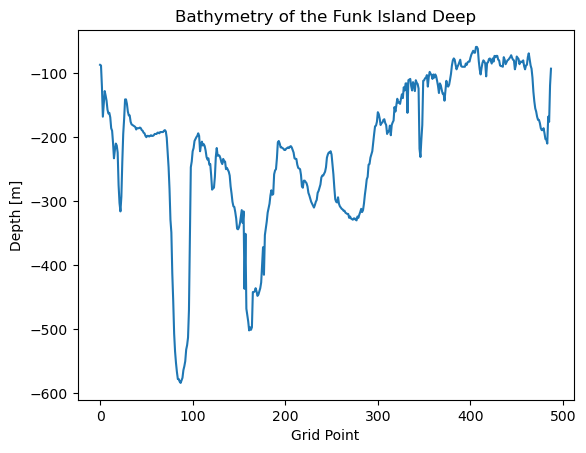

In [16]:
np.mean(bathy_line)
plt.plot(bathy_line)
plt.title('Bathymetry of the Funk Island Deep')
plt.xlabel('Grid Point')
plt.ylabel('Depth [m]');

In [17]:
poly = Polygon(polygon_coords)

line_velocities = {}
for i in range(len(sample_lons)):
    point = Point(sample_lons[i], sample_lats[i])
    
    min_dist = float('inf')
    closest_line = None  
    closest_line_index = -1 
    
    for j, line in enumerate(Line_strings):
        dist = point.distance(line)
        if dist < min_dist:
            min_dist = dist
            closest_line = line
            closest_line_index = j
    
    coords = list(closest_line.coords)
    
    dx = coords[1][0] - coords[0][0]
    dy = coords[1][1] - coords[0][1]

    line_length = np.sqrt(dx**2 + dy**2)
    line_unit_x = dx / line_length
    line_unit_y = dy / line_length
    
    u_vel = u_vals[i]
    v_vel = v_vals[i]
    depth = bathy_line[i]
    
    proj = u_vel * line_unit_x + v_vel * line_unit_y 
    
    u_perp = u_vel - (proj * line_unit_x)
    v_perp = v_vel - (proj * line_unit_y)
    
    if closest_line_index not in line_velocities:
        line_velocities[closest_line_index] = {
            'u': [], 'v': [],
            'lons': [], 'lats': [],
            'cumdist_m': [], 'bathy_line': [],
            'u_perp':[], 'v_perp':[]
        }
    
    line_velocities[closest_line_index]['u'].append(u_vel)
    line_velocities[closest_line_index]['v'].append(v_vel)
    line_velocities[closest_line_index]['u_perp'].append(u_perp)
    line_velocities[closest_line_index]['v_perp'].append(v_perp)
    line_velocities[closest_line_index]['lats'].append(sample_lats[i])
    line_velocities[closest_line_index]['lons'].append(sample_lons[i])
    line_velocities[closest_line_index]['cumdist_m'].append(cumdist_m[i])
    line_velocities[closest_line_index]['bathy_line'].append(depth)

In [18]:
# np.diff(line_velocities[0]['cumdist_m'])
from shapely.geometry.polygon import orient
poly = orient(poly, sign=1.0)

In [19]:
for line_idx in line_velocities:
    for key in line_velocities[line_idx]:
        line_velocities[line_idx][key] = np.array(line_velocities[line_idx][key])


total_flux_net   = 0.0  
total_flux_in    = 0.0   
total_flux_out   = 0.0   
fluxes = {}
velocities_x = []
velocities_y = []

for idx, data in line_velocities.items():
    u = data['u_perp']
    v = data['v_perp']
    dist = data['cumdist_m']
    depth = data['bathy_line']

    mask = ~np.isnan(u) & ~np.isnan(v) & ~np.isnan(depth) & ~np.isnan(dist)
    if np.sum(mask) < 2:
        continue
    u, v, dist, depth = u[mask], v[mask], dist[mask], depth[mask]
    
    order = np.argsort(dist)
    u = u[order]; v = v[order]; dist = dist[order]; depth = depth[order]

   
    ds = np.diff(dist)
    if np.any(ds <= 0):
        valid_pairs = ds > 0
    else:
        valid_pairs = np.ones_like(ds, dtype=bool)

    coords = list(Line_strings[idx].coords)
    x0, y0 = coords[0]; x1, y1 = coords[1]
    dx, dy = x1 - x0, y1 - y0
    seg_len = np.hypot(dx, dy)
    if seg_len == 0:
        continue

    tx, ty = dx/seg_len, dy/seg_len
    nx, ny = ty, -tx

    # flipping normal so that it points *inward* from the polygon
    mx, my = (x0 + x1) / 2.0, (y0 + y1) / 2.0
    test_point = Point(mx + 1e-1 * nx, my + 1e-1 * ny)  
    if not poly.contains(test_point):
        nx, ny = -nx, -ny

    v_n = u * nx + v * ny  
    
    velocities_x.append(v_n*nx)
    velocities_y.append(v_n*ny)
    
    node_avg_vn = 0.5 * (v_n[:-1] + v_n[1:])
    
    flux_segments = 100 * node_avg_vn * ds    

    flux_segments = flux_segments[valid_pairs]

    flux_out_segments = flux_segments[flux_segments < 0].sum()   # - is out
    flux_in_segments  = flux_segments[flux_segments > 0].sum()   # + is in

    flux_out_Sv = flux_out_segments * 1e-6  # Sv
    flux_in_Sv  = flux_in_segments  * 1e-6   

    flux_net_Sv = (flux_out_segments + flux_in_segments) * 1e-6

    fluxes[idx] = {
        "100m_net_Sv": float(flux_net_Sv),
        "100m_in_Sv":  float(flux_in_Sv),
        "100m_out_Sv": float(flux_out_Sv),
        "n_segments":  int(len(flux_segments)),
        "n_pos_segments": int(np.sum(flux_segments > 0)),
        "n_neg_segments": int(np.sum(flux_segments < 0))
    }

    total_flux_net  += flux_net_Sv
    total_flux_in   += flux_in_Sv
    total_flux_out  += flux_out_Sv

    print(f"Line {idx}: net = {flux_net_Sv:.3e} Sv, out = {flux_out_Sv:.3e} Sv, in = {flux_in_Sv:.3e} Sv "
          f"(+seg={fluxes[idx]['n_pos_segments']}, -seg={fluxes[idx]['n_neg_segments']})")

print("================================")
print(f"TOTAL net flux  = {total_flux_net:.3e} Sv")
print(f"TOTAL out (sum negative segments) = {total_flux_out:.3e} Sv")
print(f"TOTAL in  (sum positive segments) = {total_flux_in:.3e} Sv") 

Line 0: net = 1.285e+00 Sv, out = -4.143e-02 Sv, in = 1.327e+00 Sv (+seg=42, -seg=8)
Line 1: net = -6.099e-01 Sv, out = -2.394e+00 Sv, in = 1.784e+00 Sv (+seg=144, -seg=190)
Line 2: net = -3.534e-02 Sv, out = -1.411e-01 Sv, in = 1.058e-01 Sv (+seg=19, -seg=26)
Line 3: net = -3.333e-01 Sv, out = -5.008e-01 Sv, in = 1.675e-01 Sv (+seg=16, -seg=39)
TOTAL net flux  = 3.068e-01 Sv
TOTAL out (sum negative segments) = -3.077e+00 Sv
TOTAL in  (sum positive segments) = 3.384e+00 Sv


- winter:
TOTAL net flux  = 1.143e+00 Sv
TOTAL out (sum positive segments) = 4.816e+00 Sv
TOTAL in  (sum negative segments) = -3.673e+00 Sv
- summer: TOTAL net flux  = -3.590e-01 Sv
TOTAL out (sum positive segments) = 3.439e+00 Sv
TOTAL in  (sum negative segments) = -3.798e+00 Sv
- spring: TOTAL net flux  = 8.929e-03 Sv
TOTAL out (sum positive segments) = 3.679e+00 Sv
TOTAL in  (sum negative segments) = -3.670e+00 Sv
- autumn: TOTAL net flux  = 5.457e-01 Sv
TOTAL out (sum positive segments) = 3.984e+00 Sv
TOTAL in  (sum negative segments) = -3.438e+00 Sv

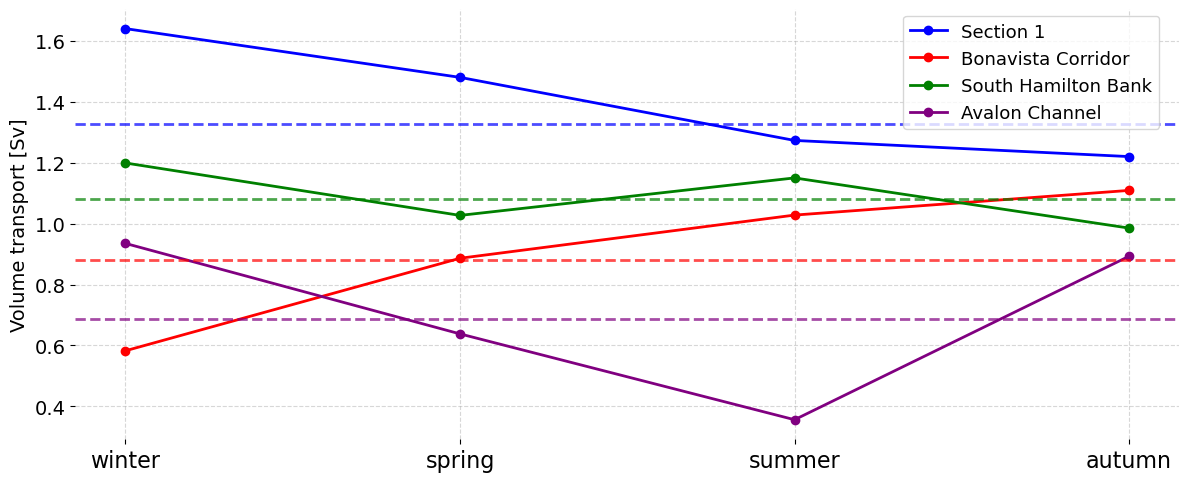

In [53]:
seasons = ["winter", "spring", "summer", "autumn"]

# flux_100 = [-1.143, -0.0089, 3.931e-01, -0.546] 
# flux_in  = [3.673, 3.670,  3.832e+00, 3.438]
# flux_out = [4.816 , 3.679, 3.439,  3.984]

flux_100 = [-5.631e-01, 6.809e-01, 1.154e+00, 6.850e-02] 
flux_in  = [3.681e+00 , 3.828e+00, 3.992e+00 , 3.611e+00]
flux_out = [4.244e+00 , 3.147e+00, 2.837e+00 ,  3.543e+00]


# net -8.813e-01, 1.327e+00 Sv, 1.081e+00 Sv, 

flux_out_bonavista = [ 5.827e-01, 8.863e-01, 1.028e+00, 1.109e+00]
flux_in_hamilton = [1.199e+00 , 1.027e+00, 1.150e+00, 9.853e-01]
flux_out_avalon = [9.350e-01, 6.381e-01, 3.564e-01, 8.930e-01]

flux_in1 = [1.640e+00, 1.48, 1.273e+00, 1.22]
flux_out1 = [-1.789e-01, -9.487e-02, -3.232e-02, -1.220e-02]

flux_in2 = [1.834e+00, 2.017, 2.272e+00, 2.06]
flux_out2 = [-3.267e+00,- 2.427, -2.513e+00, -2.446e+00]

flux_in3 = [1.419e-01, 1.446e-01, 1.446e-01, 1.094e-01]
flux_out3 = [-1.586e-01, -3.023e-01,- 3.509e-01, -3.879e-01]

flux_in4 = [5.701e-02, 2.762e-02, 1.422e-01, 4.905e-02]
flux_out4 = [-1.211e+00,- 8.545e-01, -5.433e-01,-1.137e+00]

means = [1.285e+00, -6.099e-01, -1.569e-01,-8.710e-01]
budget1 = [1.462e+00, 1.385e+00, 1.241e+00, 1.462e+00]
budget2 = [-1.433e+00, -4.101e-01, -2.401e-01, -1.433e+00 ]
budget3 = [-1.667e-02, -1.565e-01, -2.063e-01, -1.667e-02]
budget4 = [-1.154e+00, -8.269e-01, -4.011e-01,  -1.154e+00 ]

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
season_bounds = {
    "winter": (0, 2),   # Jan–Mar
    "spring": (3, 5),   # Apr–Jun
    "summer": (6, 8),   # Jul–Sep
    "autumn": (9, 11)   # Oct–Dec
}
# import seaborn as sns
# sns.set(style="ticks")
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)
# ax1.set_facecolor('darkbird')
# plt.plot(seasons, budget1,  linewidth=2, color='blue', marker='o',label='Section 1')
# plt.plot(seasons, budget2,  linewidth=2, color='red', marker='o',label='Section 2 ')
# plt.plot(seasons, budget3,  linewidth=2, color='green', marker='o',label='Section 3')
# plt.plot(seasons, budget4,  linewidth=2, color='orange', marker='o',label='Section 4')

plt.plot(seasons, flux_in1,  linewidth=2, color='blue', marker='o',label='Section 1')
plt.plot(seasons, flux_out_bonavista,  linewidth=2, color='red', marker='o',label='Bonavista Corridor')
plt.plot(seasons, flux_in_hamilton,  linewidth=2, color='green', marker='o',label='South Hamilton Bank')
plt.plot(seasons, flux_out_avalon,  linewidth=2, color='purple', marker='o',label='Avalon Channel')

plt.xticks(range(4), seasons, fontsize=16)
plt.yticks( fontsize=14)
plt.ylabel("Volume transport [Sv]", fontsize=14)
# plt.ylim(-4, 3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.text(0.01, 0.98,"(b)", fontsize=16, weight='bold', transform=plt.gca().transAxes)

# plt.axhline(1.285e+00, color='blue', linestyle='--', linewidth=2, alpha=0.7)
# plt.axhline(-6.099e-01, color='red', linestyle='--', linewidth=2, alpha=0.7)
# plt.axhline(-1.569e-01, color='green', linestyle='--', linewidth=2, alpha=0.7)
# plt.axhline(-8.710e-01, color='orange', linestyle='--', linewidth=2, alpha=0.7)

plt.axhline(1.327e+00, color='blue', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(8.813e-01, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(1.081e+00, color='green', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(6.886e-01, color='purple', linestyle='--', linewidth=2, alpha=0.7)

plt.legend(fontsize=13, bbox_to_anchor=(0.99, 0.7))
plt.grid(True, linestyle="--", alpha=0.5)
# plt.axis('off')
plt.tight_layout()
# plt.savefig('Figures/flux_result_regions.png', dpi=300)
plt.show()

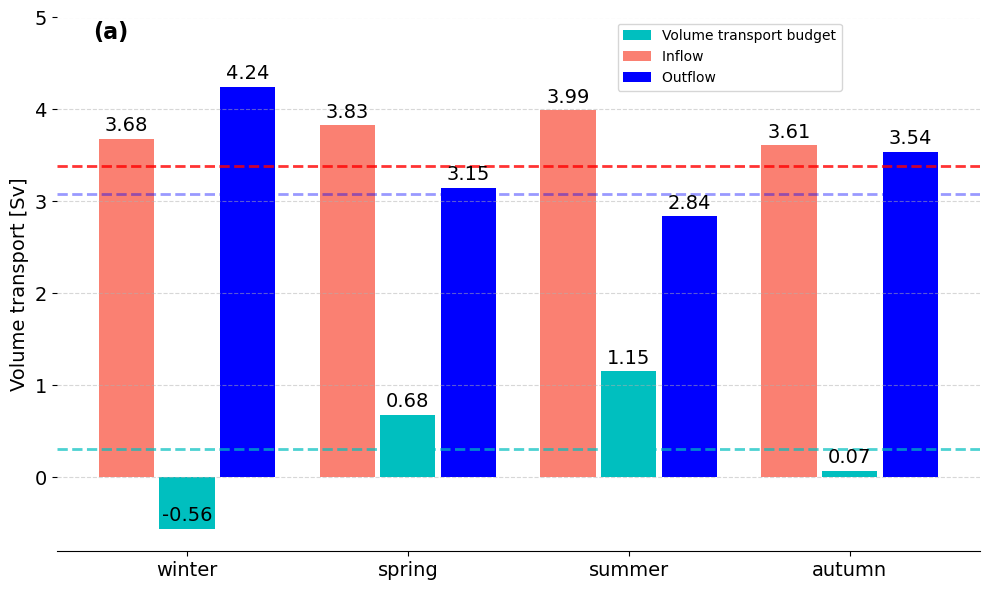

In [57]:
x = np.arange(len(seasons))  # positions
width = 0.25  # bar width

# Plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
bars1 = plt.bar(x , flux_100, width, label="Volume transport budget", color="c")
bars2 = plt.bar(x -1.1 *width, flux_in, width, label="Inflow ", color="salmon")
bars3 = plt.bar(x + 1.1 *width, flux_out, width, label="Outflow ", color="blue")

# plt.axhline(3.524e-01, color='c', linestyle='--', linewidth=2, alpha=0.7)
# plt.axhline(3.241, color='red', linestyle='--', linewidth=2, alpha=0.8)
# plt.axhline(3.594, color='blue', linestyle='--', linewidth=2, alpha=0.4)

plt.axhline(3.068e-01, color='c', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(3.384e+00, color='red', linestyle='--', linewidth=2, alpha=0.8)
plt.axhline(3.077e+00, color='blue', linestyle='--', linewidth=2, alpha=0.4)

plt.xticks(x, seasons, fontsize=14)
plt.yticks([0,1,2,3,4,5] , ['0','1','2','3','4','5'], fontsize=14)
plt.ylabel("Volume transport [Sv]", fontsize=14)

plt.legend(bbox_to_anchor=(0.6,0.85))
plt.grid(axis="y", linestyle="--", alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.text(0.04, 0.96,"(a)", fontsize=16, weight='bold', transform=plt.gca().transAxes)
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.04, f"{height:.2f}", 
                 ha='center', va='bottom',fontsize=14)
        
plt.tight_layout()
# plt.savefig('Figures/flux_result_b.png', dpi=300)
plt.show();

In [73]:
points_summer = ds_summer.ugeos.notnull().sum(dim='time')
points_winter = ds_winter.ugeos.notnull().sum(dim='time')
ssh_jul = ds_jul.ssh.mean(axis=0)
ssh_sep = ds_sep.ssh.mean(axis=0)
ssh_diff = ssh_sep - ssh_jul

In [75]:
# %matplotlib qt

In [77]:
# line_velocities['lons']

In [79]:
# print(line_velocities[2]['u_perp'])
# print(velocities_x[2])
# print(line_velocities[2]['u_perp']-velocities_x[2])

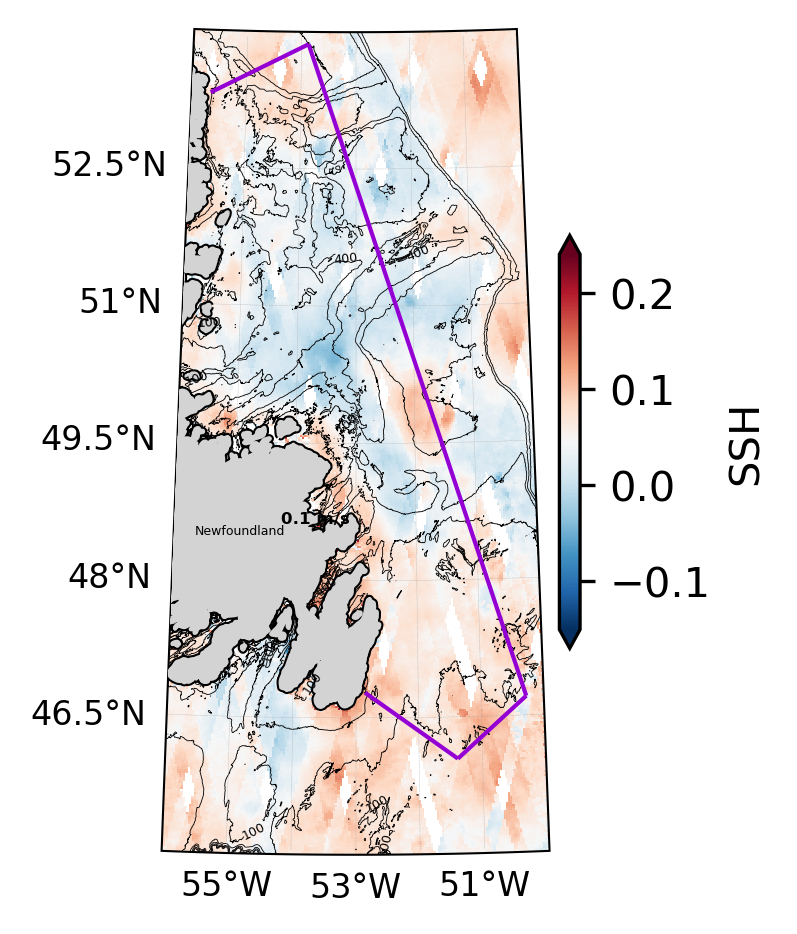

In [97]:
fig, ax, rect = plots.figure(figsize=(3, 3),nrows=1,ncols=1,region=[-56, -50, 45, 54])

plots.axis_shape(ax, rect, addCoastline=True, addCheckerboard=False)

cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.5, "pad": 0.015, "label": "SSH","orientation":"vertical"})
plot_kwargs = dict(x="lon", y="lat", cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=-0.15, vmax=0.24)
cb_args_off = dict(add_colorbar=False)

# p = DataGrid.ssh.mean(axis=0).plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=1)
p = ssh_diff.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=1)


# q = ax.quiver(line_velocities[0]['lons'], line_velocities[0]['lats'], line_velocities[0]['u_perp'], line_velocities[0]['v_perp'], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)
# ax.quiver(line_velocities[1]['lons'], line_velocities[1]['lats'], line_velocities[1]['u_perp'], line_velocities[1]['v_perp'], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)
# ax.quiver(line_velocities[2]['lons'], line_velocities[2]['lats'], line_velocities[2]['u_perp'], line_velocities[2]['v_perp'], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)
# ax.quiver(line_velocities[3]['lons'], line_velocities[3]['lats'], line_velocities[3]['u_perp'], line_velocities[3]['v_perp'], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)

# q = ax.quiver(line_velocities[0]['lons'], line_velocities[0]['lats'], velocities_x[0], velocities_y[0], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)
# ax.quiver(line_velocities[1]['lons'], line_velocities[1]['lats'], velocities_x[1], velocities_y[1], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)
# ax.quiver(line_velocities[2]['lons'], line_velocities[2]['lats'], velocities_x[2], velocities_y[2], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)
# ax.quiver(line_velocities[3]['lons'], line_velocities[3]['lats'], velocities_x[3], velocities_y[3], transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.003)


# ax.quiver(sample_lons, sample_lats, u_vals, v_vals, transform=ccrs.PlateCarree(),
#           scale=3, color='k', zorder=4, width=0.002)

# ugeos_mean = DataGrid.ugeos.where((DataGrid.ugeos <= 0.6) & (DataGrid.ugeos >= -0.6)).mean(axis=0)
# vgeos_mean = DataGrid.vgeos.where((DataGrid.ugeos <= 0.6) & (DataGrid.vgeos >= -0.6)).mean(axis=0)

# ugeos_mean = ugeos_mean.where((ugeos_mean <= 0.6) & (ugeos_mean >= -0.6))
# vgeos_mean = vgeos_mean.where((vgeos_mean <= 0.6) & (vgeos_mean >= -0.6))

# q = ax.quiver(DataGrid.lon.values[::3], DataGrid.lat.values[::3], ugeos_mean.values[::3,::3], vgeos_mean.values[::3,::3], transform=ccrs.PlateCarree(),
#           scale=5, color='deeppink', zorder=2, width=0.004)

# points = points_summer-points_winter
# scatter = points_summer.plot(ax=ax, **cb_args, transform=ccrs.PlateCarree(),vmin=0, vmax=40,cmap='seismic',zorder=1)

min_level = 100
max_level = 500
num = 5  
levels = np.linspace(min_level, max_level, num)
   
BC = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', levels=levels, 
                                       linewidths=0.2, zorder=1)

plt.clabel(BC, BC.levels[::3], fontsize=3)

ax.text(-54.9, 48.5, "Newfoundland",transform=ccrs.PlateCarree(), horizontalalignment='center', fontsize=3, zorder=3)


gdf = gpd.GeoDataFrame(geometry= Line_strings)

gdf.plot(ax=ax, color='darkviolet', linewidth=1, transform=ccrs.PlateCarree(), zorder=3)

value = 0.1
qk = ax.quiverkey(q, 0.35, 0.45, value, f'{value} m/s', 
              labelpos='N', labelsep=0.01, coordinates='figure', zorder =6, color='k',
              fontproperties={'size': 4, "weight":'bold'})
qk.set_zorder(6)

# fig.savefig("Figures/SSH_diff.png", dpi=1200)  
plt.show();